In [1]:
%matplotlib widget

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import xrayutilities as xu

import ipywidgets as ipw
from ipywidgets import interact

import fabio
from silx.io.specfile import SpecFile

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RectangleSelector

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def get_single_image(fname, n, mask=None):
    imgs = fabio.open(fname)
    img = imgs.get_frame(n).data.astype(float)
    
    if mask is not None:
        img[mask == 1] = np.nan
        
    img[514:551, :] = np.nan
    img[0, 1029] = np.nan
        
    return img

## Paths

In [3]:
base_path = r'/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO'

scan_dir = 'align'

data_path = os.path.join(base_path, scan_dir)
img_path = os.path.join(data_path, 'images')

scan_dirs = ['align']
spec_fnames = {scan_dir:os.path.join(data_path, scan_dir) for scan_dir in scan_dirs}
img_h5s = {scan_dir:glob.glob(os.path.join(img_path, f'{scan_dir}*master.h5')) for scan_dir in scan_dirs}

img_files = glob.glob(os.path.join(img_path, f'{scan_dir}*master.h5'))
scans = {os.path.basename(img_file)[:-10]:img_file for img_file in img_files}

scans

{'align_scan048': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan048_master.h5',
 'align_scan049': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan049_master.h5',
 'align_scan050': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan050_master.h5',
 'align_scan051': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan051_master.h5',
 'align_scan052': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan052_master.h5',
 'align_scan053': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan053_master.h5',
 'align_scan055': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan055_master.h5',
 'align_scan056': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan056_master.h5',
 'align_scan057': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/images/align_scan057_master.h5',
 'align_scan058': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/align/ima

## Show raw images

interactive(children=(Dropdown(description='scan', index=18, options=('align_scan048', 'align_scan049', 'align…

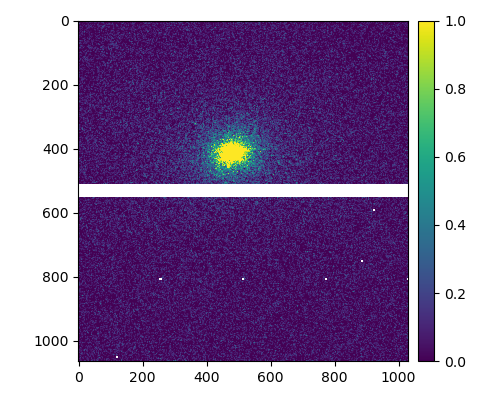

In [4]:
f1, f1_ax1 = plt.subplots(figsize=(5, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=sorted(list(scans.keys())), value=list(scans.keys())[-1])
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    img_fname = scans[scan]
    ims = fabio.open(img_fname)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(img_fname, n)
    im_arr[im_arr > 1e8] = np.nan
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

### Get ROI extents

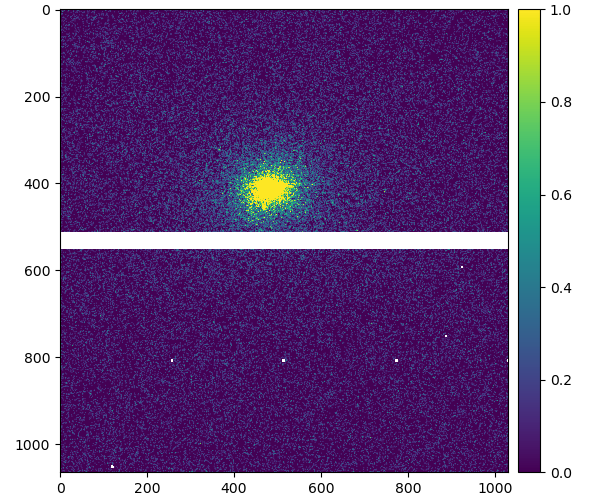

In [81]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

extent = []

im_arr = get_single_image(scans[list(scans.keys())[-1]], 0)
im_arr[im_arr > 1e8] = np.nan
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f1_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(f1_ax1, onselect, 
                                  useblit=True,
                                  button=[1, 3],  # disable middle button
                                  minspanx=5, minspany=5,
                                  spancoords='pixels',
                                  props=props, interactive=True)

### Show ROI sum

interactive(children=(Dropdown(description='scan', index=18, options=('align_scan048', 'align_scan049', 'align…

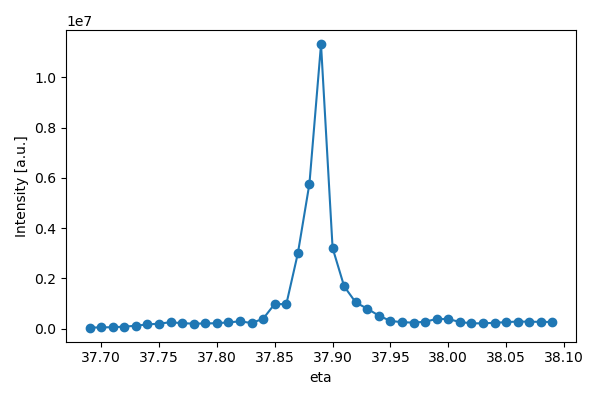

In [82]:
f2, f2_ax1 = plt.subplots(figsize=(6, 4), layout='tight')

scan_widget = ipw.Dropdown(options=list(scans.keys()), value=list(scans.keys())[-1])

@interact(
    scan=scan_widget,
)
def show_ROI_sum(scan):
    [ax.cla() for ax in f2.get_axes()]

    spec_scan_number = int(scan[-3:]) - 1
    print(spec_scan_number)
    spec_file = SpecFile(spec_fnames[scan_dir])
    spec_scan = spec_file[spec_scan_number]

    x_col = spec_file.command(spec_scan_number).split()[1]
    x_data = spec_scan.data_column_by_name(x_col)

    img_fname = scans[scan]
    ims = fabio.open(img_fname)
    
    roi_sum = []
    for im in ims:
        im_arr = im.data.astype(float)
        im_arr[im_arr > 1e8] = np.nan
        # img = imgs.get_frame(n).data
        im_arr[514:551, :] = np.nan
        im_arr[0, 1029] = np.nan
    
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f2_ax1.plot(x_data, roi_sum, 'o-')
    f2_ax1.set_xlabel(x_col)
    f2_ax1.set_ylabel('Intensity [a.u.]')

In [ ]:
<pre>H K L =  -0.98649  0.41394  2.9368	 Lambda = 1.4879 Two Theta = 73.09

    Alpha      Beta       Psi       Tau       Qaz       Naz     Omega
  31.7395   36.3642   83.0173   20.0156   90.0000   66.4544   -2.2410

       del        eta        chi        phi         nu         mu 
  73.08979   34.30387   70.69531   82.80613    0.00000    0.00000 
</pre>

In [35]:
spec_fnames

{'find_ubr': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/find_ubr/find_ubr'}

In [37]:
spec_scan = spec_file[2]

In [38]:
x_data = spec_scan.data_column_by_name('eta')

In [42]:
img_files = img_h5s[sc]

img_fnames = [os.path.basename(img_file) for img_file in img_files]

## Show raw images

interactive(children=(Dropdown(description='scan', options=('find_ubr_scan003_master.h5', 'find_ubr_scan002_ma…

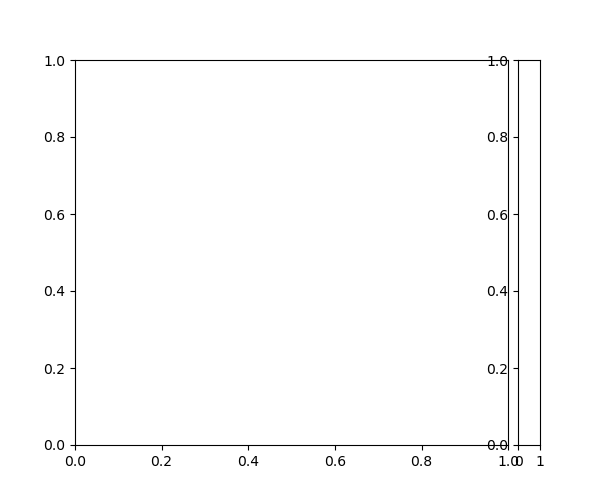

In [43]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5))

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=img_fnames)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    ims = fabio.open(scan)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(scan, n)
    im_arr[im_arr > 1e8] = np.nan
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

## Show ROI Sums

### Get ROI extents

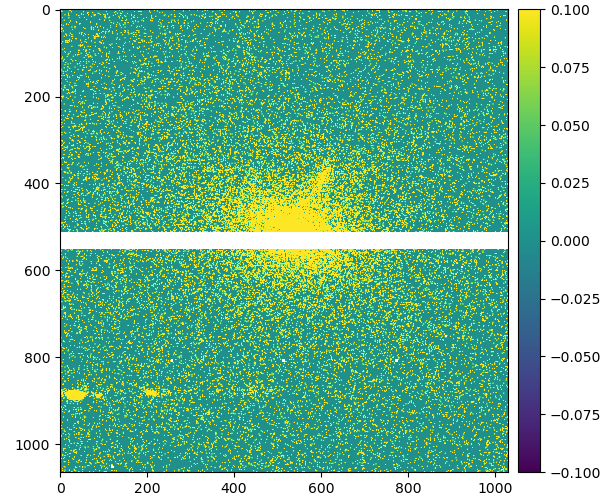

In [22]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

ims = fabio.open(scans[0])

im_arr = get_single_image(scans[0], 0)
im_arr[im_arr > 1e8] = np.nan
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f1_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
rect_selector.add_state('square')

### Show ROI sum

In [36]:
extent

[536, 241, 758, 463]

interactive(children=(Dropdown(description='scan', options=('/msd_data/checkout/bl17-2/det_psic_test/images/rm…

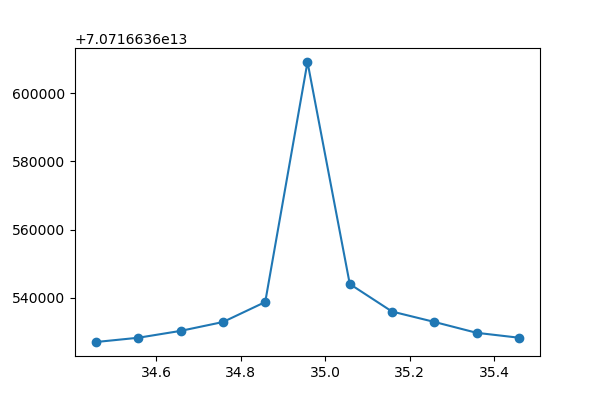

In [24]:
f2, f2_ax1 = plt.subplots(figsize=(6, 4))

scan_widget = ipw.Dropdown(options=scans)

@interact(
    scan=scan_widget,
)
def show_ROI_sum(scan):
    [ax.cla() for ax in f2.get_axes()]
    
    ims = fabio.open(scan)

    roi_sum = []
    for im in ims:
        im_arr = im.data
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f2_ax1.plot(x_data, roi_sum, 'o-')
    f2_ax1

In [25]:
int((extent[0]-0.4).round())

324

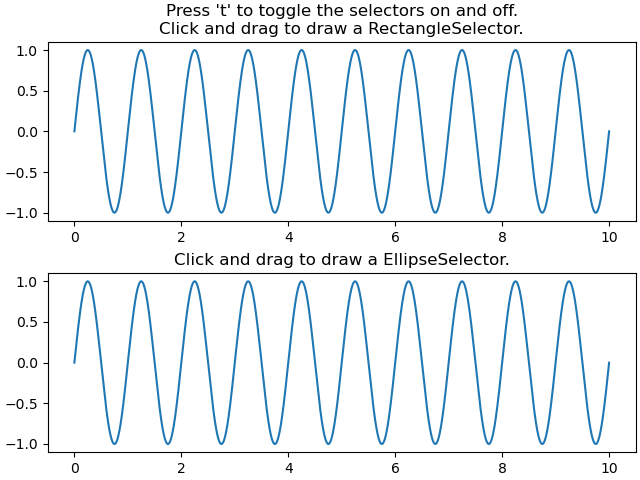

In [6]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt


def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    global extent
    
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [x1, y1, x2, y2
             ]
    print(f"({x1:3.2f}, {y1:3.2f}) --> ({x2:3.2f}, {y2:3.2f})")
    print(f"The buttons you used were: {eclick.button} {erelease.button}")
    

def toggle_selector(event):
    print('Key pressed.')
    if event.key == 't':
        for selector in selectors:
            name = type(selector).__name__
            if selector.active:
                print(f'{name} deactivated.')
                selector.set_active(False)
            else:
                print(f'{name} activated.')
                selector.set_active(True)


fig = plt.figure(layout='constrained')
axs = fig.subplots(2)

N = 100000  # If N is large one can see improvement by using blitting.
x = np.linspace(0, 10, N)

selectors = []
for ax, selector_class in zip(axs, [RectangleSelector, EllipseSelector]):
    ax.plot(x, np.sin(2*np.pi*x))  # plot something
    ax.set_title(f"Click and drag to draw a {selector_class.__name__}.")
    selectors.append(selector_class(
        ax, select_callback,
        useblit=True,
        button=[1, 3],  # disable middle button
        minspanx=5, minspany=5,
        spancoords='pixels',
        interactive=True))
    fig.canvas.mpl_connect('key_press_event', toggle_selector)
axs[0].set_title("Press 't' to toggle the selectors on and off.\n"
                 + axs[0].get_title())
plt.show()

In [8]:
extent

[3.8282941186148296,
 -0.5092067238051216,
 5.959990897119711,
 0.4896137238032865]